In [1]:
import requests
import json
import pandas as pd
import numpy as np
import time
from tqdm.notebook import tqdm

import math
from datetime import datetime, timezone, timedelta

import backtrader as bt
import backtrader.feeds as btfeeds

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:

def get_coin_snapshot(symbol: str, interval: str = "15m"):
    curr = datetime.now(timezone.utc)
    start = (curr - timedelta(days=2)) if interval == "15m" else curr - timedelta(days=3)
    startTime = int(datetime(start.year, start.month, start.day, start.hour, math.floor(start.minute / 15) * 15, 0).timestamp() * 1000)
    endTime = int(curr.timestamp() * 1000)
    
    url = "https://api.hyperliquid.xyz/info"
    headers = {"Content-Type": "application/json"}
    body = {
        "type": "candleSnapshot",
        "req": {
            "coin": symbol,
            "interval": interval,
            "startTime": startTime,
            "endTime": endTime
        }
    }
    resp = requests.post(url, headers=headers, json=body)
    if resp.status_code == 200:
        data = resp.json()
        
        if data:
            ticks = [{ "symbol": symbol, "time": t.get("t"), "open": round(float(t.get("o")), 6), "high": round(float(t.get("h")), 6), "low": round(float(t.get("l")), 6), "close": round(float(t.get("c")), 6), "count": t.get("n"), "volume": round(float(t.get("v")), 6)} for t in data]
            df = pd.DataFrame(ticks)
            df = df.sort_values(by=['time'])
            df['chg'] = df['close'].pct_change(periods = 1, fill_method='backfill')
            # Set the decay factor
            decay_factor = 0.75  # Adjust this as desired

            # Calculate the decay weights
            df['weight'] = np.exp(decay_factor * ((df['time'] - df['time'].max()) / (1 * 24 * 60 * 60* 1000)))
            return df
        else:
            return None
    else:
        return None

In [4]:
BTVERSION = tuple(int(x) for x in bt.__version__.split('.'))


class FixedPerc(bt.Sizer):
    '''This sizer simply returns a fixed size for any operation

    Params:
      - ``perc`` (default: ``0.20``) Perc of cash to allocate for operation
    '''

    params = (
        ('perc', 0.20),  # perc of cash to use for operation
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        cashtouse = self.p.perc * cash
        if BTVERSION > (1, 7, 1, 93):
            size = comminfo.getsize(data.close[0], cashtouse)
        else:
            size = cashtouse // data.close[0]
        return size

In [5]:
class TheStrategy(bt.Strategy):
    '''
    This strategy is loosely based on some of the examples from the Van
    K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

      - Enter the market if:
        - The MACD.macd line crosses the MACD.signal line to the upside
        - The Simple Moving Average has a negative direction in the last x
          periods (actual value below value x periods ago)

     - Set a stop price x times the ATR value away from the close

     - If in the market:

       - Check if the current close has gone below the stop price. If yes,
         exit.
       - If not, update the stop price if the new stop price would be higher
         than the current
    '''

    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 3.0),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
    )
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def notify_order(self, order):
        if order.status == order.Completed:
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
                elif order.issell():
                    self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            pass

        if not order.alive():
            self.order = None  # indicate no order is pending
            
    def notify_trade(self, trade):
        #self.log(trade)
        self.log(f"Trade executed (id={trade.tradeid}): size={trade.size}, price={trade.price} [val={trade.value}] (comm={trade.commission}, pnl={trade.pnl}, pnlcomm={trade.pnlcomm})")

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

        # To set the stop price
        self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
        self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
        self.smadir = self.sma - self.sma(-self.p.dirperiod)

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        if self.order:
            return  # pending order execution

        if not self.position:  # not in the market
            if self.mcross[0] > 0.0 and self.smadir < 0.0:
                self.order = self.buy()
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] - pdist

        else:  # in the market
            pclose = self.data.close[0]
            pstop = self.pstop

            if pclose < pstop:
                self.close()  # stop met - get out
            else:
                pdist = self.atr[0] * self.p.atrdist
                # Update only if greater than
                self.pstop = max(pstop, pclose - pdist)

In [17]:
def runstrat(symbol: str, args=None):
    #args = parse_args(args)
    args = {
        "cash": 100000,
        "commperc": 0.002,
        "cashalloc": 0.98,
        "macd1": 12,
        "macd2": 26,
        "macdsig": 9,
        "atrperiod": 14,
        "atrdist": 3.0,
        "smaperiod": 30,
        "dirperiod": 10,
        "riskfreerate": 0.01,
    }

    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(args.get('cash'))
    comminfo = bt.commissions.CommInfo_Stocks_Perc(commission=args.get('commperc'),
                                                   percabs=True)

    cerebro.broker.addcommissioninfo(comminfo)

    dkwargs = dict()
    #if args.fromdate is not None:
    #    fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d')
    #    dkwargs['fromdate'] = fromdate

    #if args.todate is not None:
    #    todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d')
    #    dkwargs['todate'] = todate

    # if dataset is None, args.data has been given
    #dataname = DATASETS.get(args.dataset, args.data)
    
    #data0 = bt.feeds.YahooFinanceCSVData(dataname=dataname, **dkwargs)
    
    # Get a pandas dataframe
    df_5min = get_coin_snapshot(symbol, "30m")
    
    # Transform datetimep
    df_5min["time"] = df_5min['time'].apply(lambda x: datetime.fromtimestamp(x / 1000))
    df_5min = df_5min.set_index("time")
    #dkwargs['fromdate'] = df_5min.iloc[0].index
    #dkwargs['todate'] = df_5min.iloc[-1].index
    data0 = bt.feeds.PandasData(dataname=df_5min)
    
    cerebro.adddata(data0)

    cerebro.addstrategy(TheStrategy,
                        macd1=args.get('macd1'), macd2=args.get('macd2'),
                        macdsig=args.get('macdsig'),
                        atrperiod=args.get('atrperiod'),
                        atrdist=args.get('atrdist'),
                        smaperiod=args.get('smaperiod'),
                        dirperiod=args.get('dirperiod'))

    cerebro.addsizer(FixedPerc, perc=args.get('cashalloc'))

    # Add TimeReturn Analyzers for self and the benchmark data
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='alltime_roi',
                        timeframe=bt.TimeFrame.NoTimeFrame)

    cerebro.addanalyzer(bt.analyzers.TimeReturn, data=data0, _name='benchmark',
                        timeframe=bt.TimeFrame.NoTimeFrame)

    # Add TimeReturn Analyzers fot the annuyl returns
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Years)
    # Add a SharpeRatio
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Years,
                        riskfreerate=args.get('riskfreerate'))

    # Add SQN to qualify the trades
    cerebro.addanalyzer(bt.analyzers.SQN)
    cerebro.addobserver(bt.observers.DrawDown)  # visualize the drawdown evol

    results = cerebro.run()
    st0 = results[0]

    for alyzer in st0.analyzers:
        alyzer.print()

    #if args.plot:
    pkwargs = dict(style='candle')
        #if args.plot is not True:  # evals to True but is not True
        #    npkwargs = eval('dict(' + args.plot + ')')  # args were passed
        #    pkwargs.update(npkwargs)

    cerebro.plot(**pkwargs)

2024-03-10 BUY EXECUTED, 3901.30
2024-03-10 Trade executed (id=0): size=25, price=3901.3 [val=97532.5] (comm=195.06500000000003, pnl=0.0, pnlcomm=-195.06500000000003)
2024-03-10 SELL EXECUTED, 3902.00
2024-03-10 Trade executed (id=0): size=0, price=3901.3 [val=0.0] (comm=390.1650000000001, pnl=17.499999999995453, pnlcomm=-372.6650000000046)
2024-03-11 BUY EXECUTED, 3869.20
2024-03-11 Trade executed (id=0): size=25, price=3869.2 [val=96730.0] (comm=193.46, pnl=0.0, pnlcomm=-193.46)
2024-03-12 SELL EXECUTED, 4007.90
2024-03-12 Trade executed (id=0): size=0, price=3869.2 [val=0.0] (comm=393.855, pnl=3467.500000000007, pnlcomm=3073.645000000007)
TimeReturn:
  - 9999-12-31 23:59:59.999999: 0.02700979999999986
TimeReturn:
  - 9999-12-31 23:59:59.999999: 0.021798225368005353
TimeReturn:
  - 2024-12-31: 0.02700979999999986
SharpeRatio:
  - sharperatio: None
SQN:
  - sqn: 1.1083630165883143
  - trades: 2


<IPython.core.display.Javascript object>


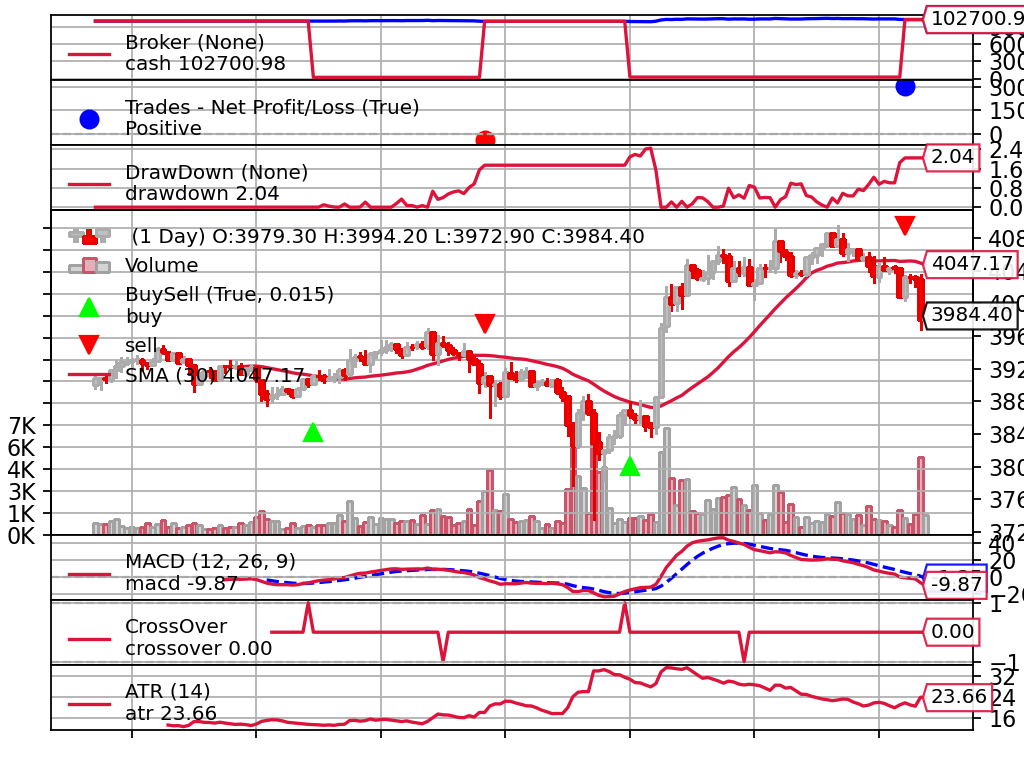

In [18]:
runstrat("ETH")